### Construct Kinematic Chain using `networkx` package

In [78]:
import copy,cv2,glob,os
import numpy as np
import mediapy as media
import networkx as nx
import matplotlib.pyplot as plt
from util import rpy2r,create_folder_if_not_exists, rpy2R
from mujoco_parser import MuJoCoParserClass
from kin_chain import KinematicChainClass
np.set_printoptions(precision=2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("networkx version:[%s]"%(nx.__version__))

networkx version:[3.1]


### Load bvh & Initialize kinematic chain

Reading BVH file...
done
Building skeleton...
done
Analyzing frames...
done


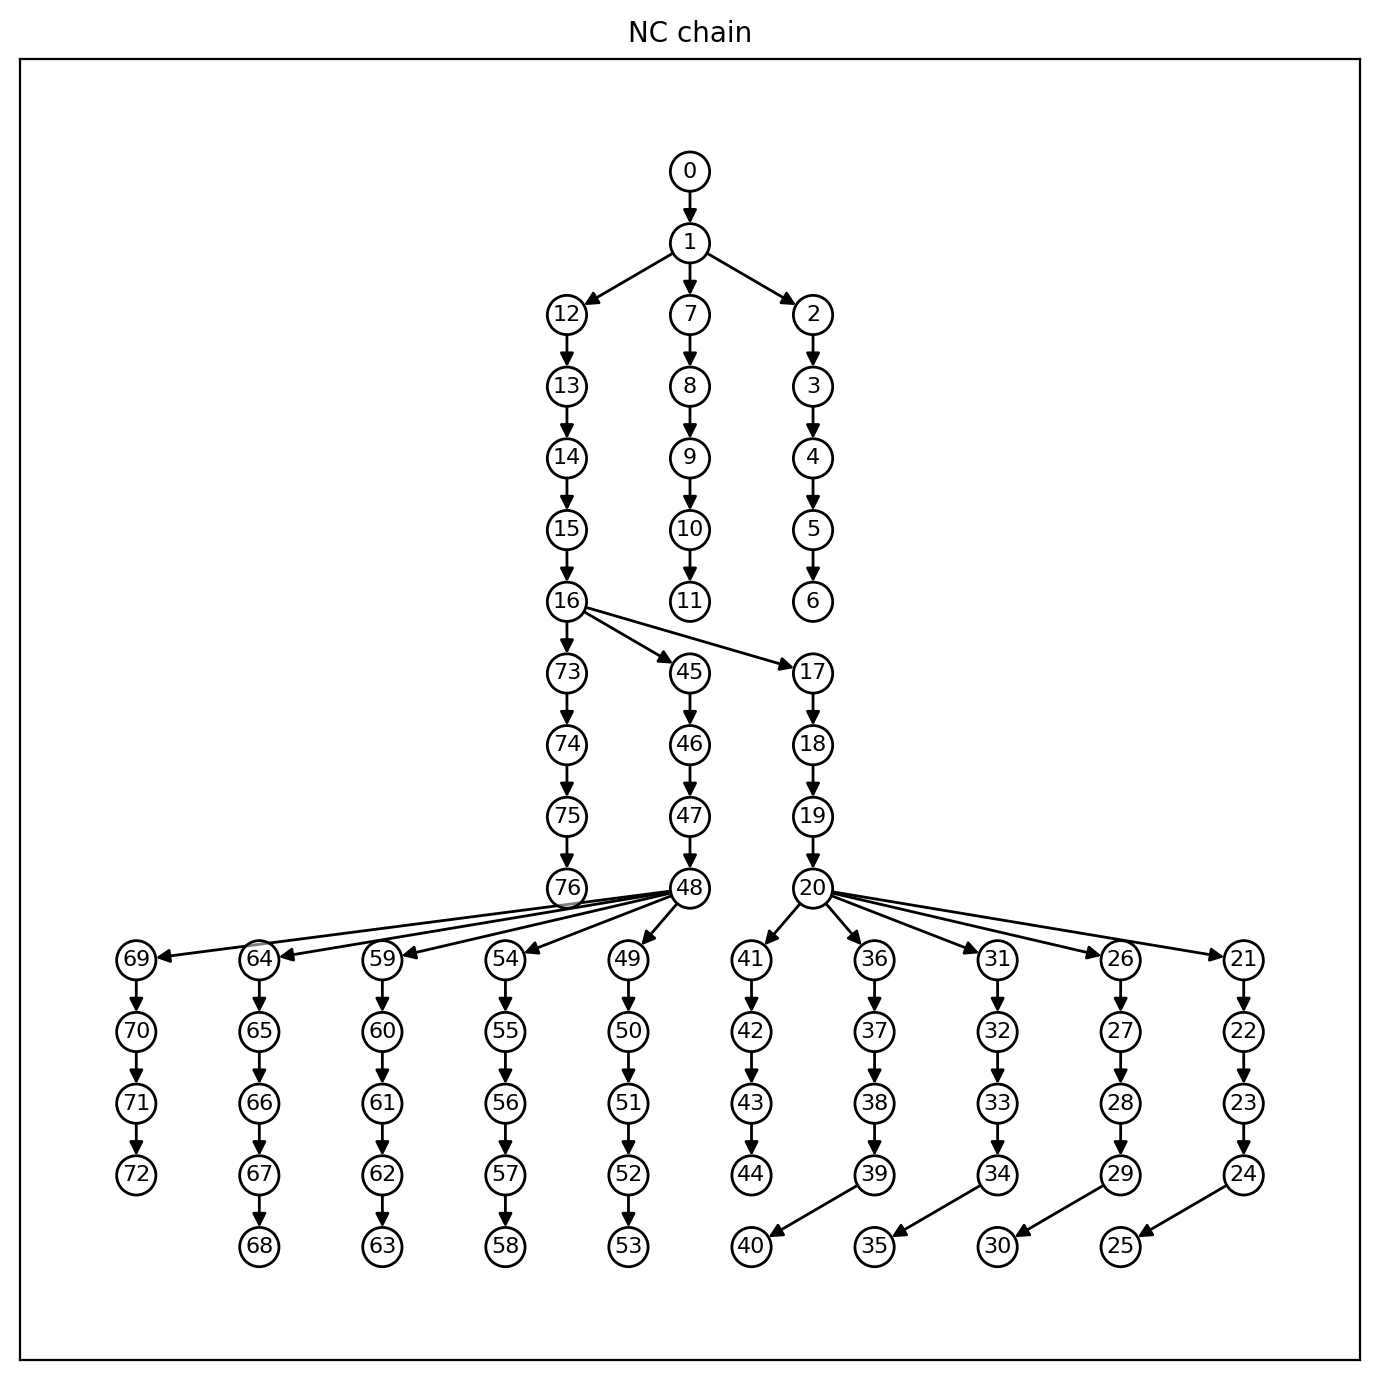

[0/77] joint name:[World] p:[0 0 0] rpy_deg:[0. 0. 0.]
[1/77] joint name:[pelvis] p:[0.  0.  1.8] rpy_deg:[ 0. -0.  0.]
[2/77] joint name:[thigh_r] p:[1.  0.  1.8] rpy_deg:[ 0. -0.  0.]
[3/77] joint name:[calf_r] p:[0.98 4.45 1.66] rpy_deg:[ 0. -0.  0.]
[4/77] joint name:[foot_r] p:[0.98 8.82 1.66] rpy_deg:[ 0. -0.  0.]
[5/77] joint name:[ball_r] p:[0.98 9.58 3.13] rpy_deg:[ 0. -0.  0.]
[6/77] joint name:[ball_rEnd] p:[0.98 9.58 3.13] rpy_deg:[ 0. -0.  0.]
[7/77] joint name:[thigh_l] p:[-1.   0.   1.8] rpy_deg:[ 0. -0.  0.]
[8/77] joint name:[calf_l] p:[-0.98 -4.45  1.94] rpy_deg:[ 0. -0.  0.]
[9/77] joint name:[foot_l] p:[-0.98 -8.82  1.94] rpy_deg:[ 0. -0.  0.]
[10/77] joint name:[ball_l] p:[-0.98 -9.58  0.47] rpy_deg:[ 0. -0.  0.]
[11/77] joint name:[ball_lEnd] p:[-0.98 -9.58  0.47] rpy_deg:[ 0. -0.  0.]
[12/77] joint name:[spine_01] p:[0.   0.56 1.78] rpy_deg:[ 0. -0.  0.]
[13/77] joint name:[spine_02] p:[0.   1.22 1.78] rpy_deg:[ 0. -0.  0.]
[14/77] joint name:[spine_03] p:[0.   2

In [79]:
from bvh.skeleton import process_bvhfile, process_bvhkeyframe
from collections import deque

data_number = "11_01"
mocap = process_bvhfile("../data/bvh/VAAI_DIRECT_" + data_number + "_a_M1.bvh", DEBUG=False)

node = mocap.root
deq = deque()
joint_names = []

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

rot = np.array(rot)
rot = rot[:, 1:].reshape(rot.shape[0], -1, 3)[:, :, [2, 0, 1]]

pos = np.array(pos)/10
pos = pos[:, 1:].reshape(pos.shape[0], -1, 3)[:, :, [2, 0, 1]]


kin_chain = KinematicChainClass(name='NC chain')
kin_chain.add_joint(name='World',p=np.array([0,0,0]),R=rpy2r(np.radians([0,0,0])))

kin_chain.add_joint(name=node.name,parent_name='World',
        p_offset=np.array([0,0,1.8]),R_offset=rpy2r(np.radians([0,0,0])))
joint_names.append(node.name)
while len(node.children) > 0 or len(deq) > 0:
    if len(deq) > 0:
        node = deq.pop()
        kin_chain.add_joint(name=node.name,parent_name=node.parent.name,
                p_offset=np.array(node.strans)[[2,0,1]]/10,R_offset=rpy2r(np.radians([0,0,0]))
                )
        joint_names.append(node.name)

    for child in node.children:
        deq.append(child)

# Plot chain
kin_chain.plot_chain_graph(figsize=(7,7),node_size=200,font_size_node=8,font_size_title=10)
# Print chain info
kin_chain.forward_kinematics()
kin_chain.print_chain_info()

### Visualization

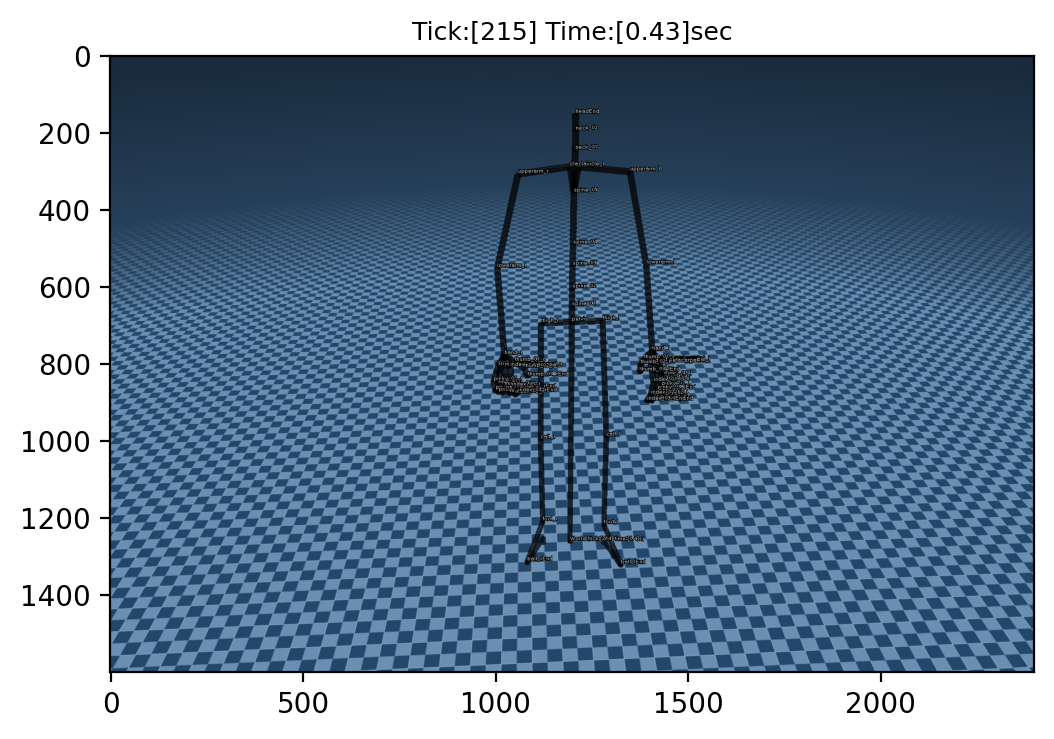

In [80]:
import os
import cv2

CHECK_LOOP = False
SAVE_VIDEO = False

video = []
tick = 0

L = pos.shape[0]
p_joints = np.empty_like(pos)
R_offset_joints = np.empty((pos.shape[0], pos.shape[1], 3, 3))

# Initialize MuJoCo viewer
xml_path = '../asset/object/floor_sky.xml'
env = MuJoCoParserClass(name='Floor',rel_xml_path=xml_path,VERBOSE=False)
env.init_viewer(viewer_title='Kinematic Chain',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=177,distance=25.0,elevation=-30,lookat=[0.0,0.1,8],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset()

while tick < L:
    # Step
    env.step()
    i = tick % rot.shape[0]

    # Forward Kinematics
    R_offsets = []
    kin_chain.chain.nodes[1]['p_offset'] = pos[i, 0, :]
    
    for j in range(rot.shape[1]):
        R_offsets.append(rpy2R(np.radians(rot[i,j]), [0,2,1]))
        R_offset_joints[i-1, j, :, :] = rpy2R(np.radians(rot[i,j]), [0,2,1])

    kin_chain.set_R_offset(joint_names, R_offsets)
    kin_chain.forward_kinematics()
    for j, joint_name in enumerate(joint_names):
        kin_chain.chain.nodes[kin_chain.get_joint_idx(joint_name)]['p'] =  kin_chain.chain.nodes[kin_chain.get_joint_idx(joint_name)]['p'][[2,1,0]]
        kin_chain.chain.nodes[kin_chain.get_joint_idx(joint_name)]['p'][0] *= -1
        p_joints[i-1, j, :] = kin_chain.chain.nodes[kin_chain.get_joint_idx(joint_name)]['p']

    # Render
    if env.loop_every(tick_every=1):
        env.plot_T(p=np.zeros(3,),R=np.eye(3),
                   PLOT_AXIS=True,axis_len=0.1,axis_width=0.01,PLOT_SPHERE=False,
                   label='World (tick:[%d] time:[%.1f]s)'%(tick,env.get_sim_time()))
        # Plot chain in MuJoCo
        kin_chain.plot_chain_mujoco(env,r_link=0.1)
        
        env.render()
        frame = env.grab_image()
        video.append(frame)
        
    tick = tick + 1
    if tick == L:
        if CHECK_LOOP: tick = 0

env.close_viewer()

# Plot the final scene
plt.figure(figsize=(6,4)); plt.imshow(frame)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()

if SAVE_VIDEO:
    shape = video[0].shape
    video_folder = ("../video/")
    if not os.path.isdir(video_folder): os.mkdir(video_folder)

    video_path = os.path.join(video_folder, data_number[:2] + "baseline.mp4")
    video_fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    fps = 50
    video_out = cv2.VideoWriter(video_path, video_fourcc, fps, (shape[1], shape[0]), True)

    for i in range(len(video)):
        video_frame = cv2.cvtColor(video[i], cv2.COLOR_BGR2RGB)
        video_out.write(video_frame)
    video_out.release()